## Analyse de trajectoires à l'aide d'un vélo instrumenté
Ce notebook sert à analyser des trajectoires en vélo. Il permet de déterminer la puissance mécanique transférée par le cycliste au vélo. Il est ainsi possible de comparer les données issues du modèle et les données issues de capteurs de puissance (pédales).

In [1]:
import pylab
import gpxpy
import gpxpy.gpx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from scipy import interpolate

import folium
from folium import plugins, IFrame
from folium.features import *

import os
import pandas as pd
dir = os.path.dirname(os.path.realpath('__file__'))
pylab.rcParams['figure.figsize'] = (24.0, 12.0) #configure the figure

def lon_lat_to_xy(lon, lat, R = 6371000.0):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r[0]) * lon_r
    y = R * lat_r
    return x,y,

def lon_lat_to_cartesian(lon, lat, R = 6371000.0):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x,y,z

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

def rot(v,theta,alpha):
    
    R = ([[np.cos(theta)*np.cos(alpha), -np.sin(theta), -np.cos(theta)*np.sin(alpha)], [np.sin(theta)*np.cos(alpha), np.cos(theta), np.sin(theta)*np.sin(alpha)], [np.sin(alpha)], 0., np.cos(alpha)])
    RT=np.transpose(R)
    return R*V

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [2]:
#Données du système
m = 73. #@param {type: "number"} #kg, masse cycliste + vélo
A = 0.45 #m^2
C_x = 0.825
mu = 0.004

#Données génerales, constantes
rho = 1.1 #kg.m^-3 densité de l'air
g = 9.81 #m.s^-2

In [3]:
# Parsing an existing file:
# -------------------------

file_name = 'transfer_run2/PDP_Hangar_14_run_2.csv'
df = pd.read_csv(file_name, sep=',')

points = df[['lat', 'lon']].apply(tuple, axis=1)
mymap = folium.Map( location=[ df.lat.mean(), df.lon.mean() ], zoom_start=10, tiles=None)
folium.TileLayer('Stamen Terrain', name='Stamen Terrain').add_to(mymap)
folium.PolyLine(points, color='red', weight=4.5, opacity=.5).add_to(mymap)
mymap

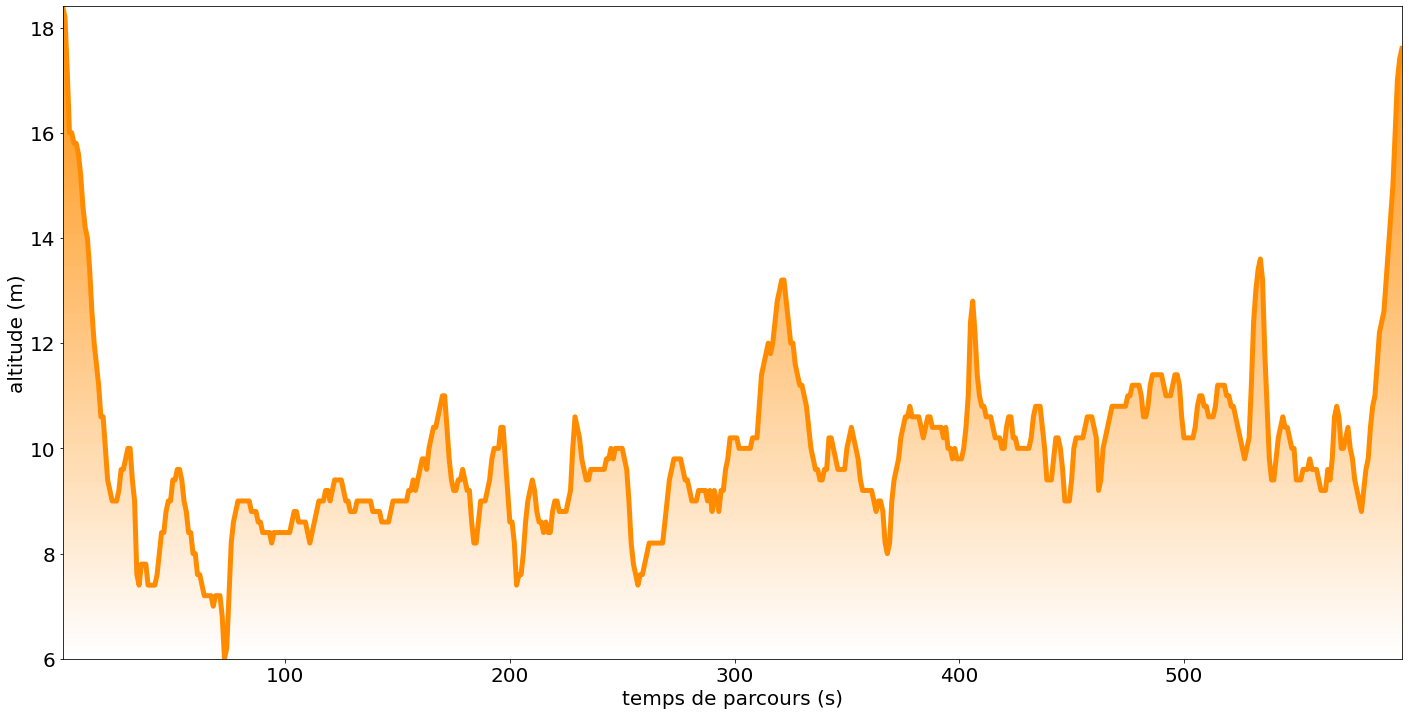

In [10]:
#afficher le profil du parcours (altitude en fonction de la distance)
t = df['secs'].values
z = df['alt'].values

fig = plt.figure()
gradient_fill(t,z, color='darkorange', linewidth=5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('temps de parcours (s)', fontsize=20)
plt.ylabel('altitude (m)', fontsize=20)
plt.show()
fig.savefig('profil_altimetrique.png', dpi=200) 

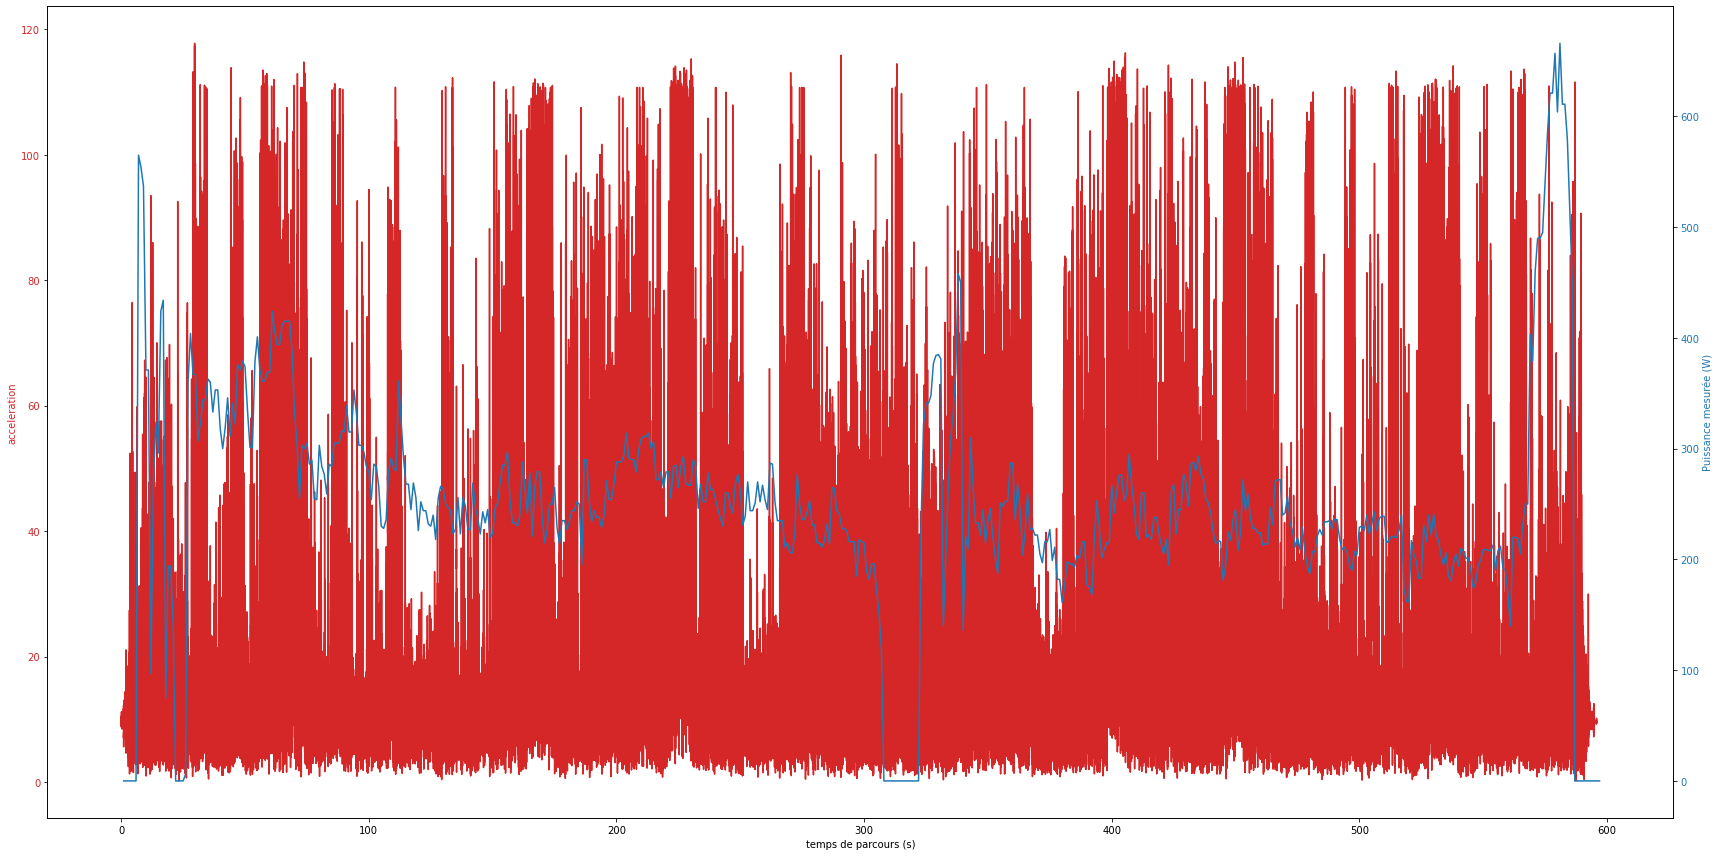

In [9]:
# Parsing an existing file:
# -------------------------

accelerometer_name = 'transfer_run2/Accelerometer.csv'
acc = pd.read_csv(accelerometer_name, sep='\t')
acc.columns = ['time', 'a_x', 'a_y', 'a_z']

t_acc = acc['time'].values
a_x_acc = acc['a_x'].values
a_y_acc = acc['a_y'].values
a_z_acc = acc['a_z'].values
a_norm_acc = np.sqrt(a_x_acc**2. + a_y_acc**2. + a_z_acc**2)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('temps de parcours (s)')
ax1.set_ylabel('acceleration', color=color)
ax1.plot(t_acc,a_norm_acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Puissance mesurée (W)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, df['watts'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()